# Exploring Brain Activity with Siibra: Analyzing Group-Level fMRI Results Using Python

__Author:__ Moni Dörig

This notebook has been tested on [Neurodesk Version 24-04-04](https://hub.docker.com/layers/vnmd/neurodesktop/2024-04-04/images/sha256-5f7b1836e5dc33945d27bfbf91011bb21c4019e7c650b02f22edf313b1d33db4?context=explore)

References:

__Siibra:__
- Timo Dickscheid, Xiayun Gui, Ahmet Nihat Simsek, Vadim Marcenko, Louisa Köhnen, Sebastian Bludau, & Katrin Amunts. (2023). siibra-python - Software interface for interacting with brain atlases. Zenodo. https://doi.org/10.5281/zenodo.7885728.

- Version used in this notebook: __Version v1.0a14__: https://doi.org/10.5281/zenodo.12636715

__Dataset:__
- Dimitri Papadopoulos Orfanos, Vincent Michel, Yannick Schwartz, Philippe Pinel, Antonio Moreno, Denis Le Bihan, and Vincent Frouin. The brainomics/localizer database. NeuroImage, 144:309–314, 2017. Data Sharing Part II. URL: https://www.sciencedirect.com/science/article/pii/S1053811915008745, doi:https://doi.org/10.1016/j.neuroimage.2015.09.052.


__Neurodesk__:
- Renton, A.I., Dao, T.T., Johnstone, T. et al. Neurodesk: an accessible, flexible and portable data analysis environment for reproducible neuroimaging. Nat Methods (2024). https://doi.org/10.1038/s41592-023-02145-x
- [Neurodesk Website](https://www.neurodesk.org/)

In [1]:
%%capture
! pip install siibra nilearn 

In [2]:
from nilearn import datasets, plotting, image, glm
import siibra
import nibabel as nib
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from nibabel.processing import resample_from_to

[siibra:INFO] Version: 1.0a14
[siibra:WARNING] This is a development release. Use at your own risk.
[siibra:INFO] Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.


## 1. Fetch data from the 'Functional Localizer dataset' (SPM first level results) for 16 subjects
Dataset description from nilearn.datasets: “The Functional Localizer is a simple and fast acquisition procedure based on a 5-minute functional magnetic resonance imaging (fMRI) sequence that can be run as easily and as systematically as an anatomical scan. This protocol captures the cerebral bases of auditory and visual perception, motor actions, reading, language comprehension and mental calculation at an individual level. Individual functional maps are reliable and quite precise. The procedure is described in more detail on the Functional Localizer page.” (see https://osf.io/vhtf6/)

In [3]:
n_subjects = 16
data = datasets.fetch_localizer_contrasts(
    ["left vs right button press"],
    n_subjects,
    legacy_format=False,
)

# print basic information on the dataset
print(
    "First contrast nifti image (3D) is located "
    f"at: {data.cmaps[0]}"
)

First contrast nifti image (3D) is located at: /home/jovyan/nilearn_data/brainomics_localizer/brainomics_data/S01/cmaps_LeftAuditory&VisualClickVsRightAuditory&VisualClick.nii.gz


## 2. Estimate second level model

In [4]:
second_level_input = data["cmaps"]
design_matrix = pd.DataFrame(
    [1] * len(second_level_input), columns=["intercept"]
)

In [5]:
second_level_model = glm.second_level.SecondLevelModel(smoothing_fwhm=8.0, n_jobs=2)
second_level_model = second_level_model.fit(
    second_level_input, design_matrix=design_matrix
)

In [6]:
z_map = second_level_model.compute_contrast(output_type="z_score")

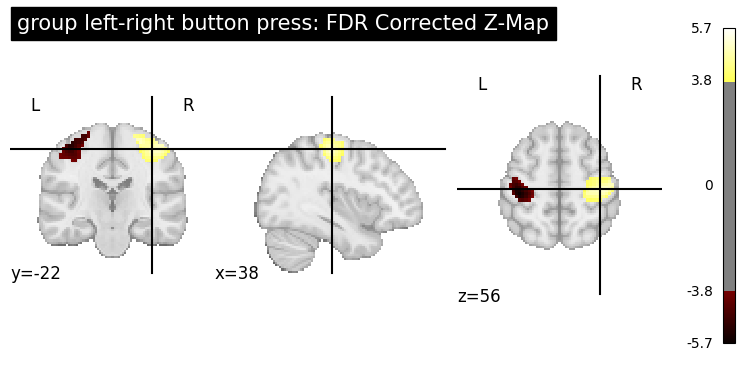

In [7]:
# Multiple Comparison
thresholded_map, threshold = glm.threshold_stats_img(z_map, alpha=0.01, height_control="fdr", cluster_threshold=10)

# Plot the thresholded z-map
plotting.plot_stat_map(
    thresholded_map, 
    title="group left-right button press: FDR Corrected Z-Map", 
    threshold=threshold, 
    cmap='hot'
)

## 3. Get parcellations maps and binary masks of regional maps from siibra

### Select the maximum probability map of Julich-Brain in MNI152 space, which is a parcellation map with discrete labels

Loading preconfigured Parcellation instances: 100%|██████████| 28/28 [00:00<00:00, 312.10Parcellation/s]
[siibra:INFO] Multiple elements matched the specification 'julich 3' - the first in order was chosen: Julich-Brain Cytoarchitectonic Atlas (v3.1)
Loading preconfigured Map instances: 100%|██████████| 60/60 [00:00<00:00, 125.03Map/s]
[siibra:WARNING] Map registry contains multiple classes: SparseMap, Map
Loading preconfigured Space instances: 100%|██████████| 9/9 [00:00<00:00, 4338.44Space/s]
[siibra:INFO] Merging fragments [left hemisphere, right hemisphere]. You can select one using NiftiProvider.fetch(fragment=<name>).
/opt/conda/lib/python3.11/site-packages/nilearn/image/resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


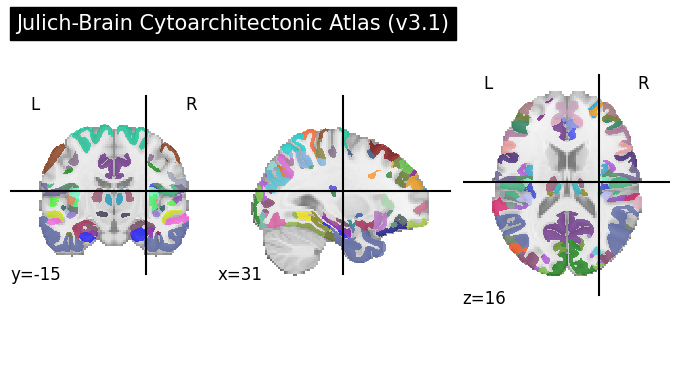

In [8]:
julich_mpm = siibra.get_map(space="icbm 2009c", parcellation="julich 3", maptype="labelled")

# Like reference templates, parcellation maps may provide more than one volume to support different formats, especially both mesh and image representations. 
# To access the actual image data, we call the fetch() method. Per default, this gives us a Nifti1Image object if image data is available for the volume.

assert julich_mpm.provides_image
mapimg = julich_mpm.fetch()

#  Plot the image with nilearn. Some maps even provide their own predefined colormap for this purpose.
cmap = julich_mpm.get_colormap()
plotting.plot_roi(
    mapimg, title=f"{julich_mpm.parcellation.name}", cmap=cmap, cut_coords=(31, -15, 16)
)

In [9]:
atlas = siibra.atlases.get('human')
julich_brain = atlas.parcellations.get('julich 3.0.3')
print("Name:    ", julich_brain.name)
print("Id:      ", julich_brain.id)
print("Modality:", julich_brain.modality)
print()
print(julich_brain.description)
print()
for p in julich_brain.publications:
    print(p['citation'])

Loading preconfigured Atlas instances: 100%|██████████| 4/4 [00:00<00:00, 6901.36Atlas/s]

Name:     Julich-Brain Cytoarchitectonic Atlas (v3.0.3)
Id:       minds/core/parcellationatlas/v1.0.0/94c1125b-b87e-45e4-901c-00daee7f2579-300
Modality: cytoarchitecture

This dataset contains the Julich-Brain Atlas, Cytoarchitectonic maps in different coordinate spaces. The parcellation provided by the Atlas is derived from the individually released probability maps (PMs) of cytoarchitectonically defined cortical and subcortical brain regions. For the whole-brain parcellation, the available PMs are combined into a maximum probability map (MPM) by considering for each voxel the probability of all cytoarchitectonic brain regions, and determining the most probable assignment. In later versions of this dataset, gap maps complement the maximum probability map of the cytoarchitectonically defined brain regions to achieve full cortical coverage. 
There are two sets of PMs with a different degree of parcellation included. The set with 157 PMs corresponds to the usual granularity of the Julich

#### Find desired brain regions

In [10]:
# Access a certain region
postCG = julich_brain.get_region("postcentral gyrus")

# Render the subtree 
postCG.render_tree()

postcentral gyrus
├── Area 3b (PostCG)
│   ├── Area 3b (PostCG) right
│   ╰── Area 3b (PostCG) left
├── Area 1 (PostCG)
│   ├── Area 1 (PostCG) right
│   ╰── Area 1 (PostCG) left
├── Area 2 (PostCS)
│   ├── Area 2 (PostCS) right
│   ╰── Area 2 (PostCS) left
╰── Area 3a (PostCG)
    ├── Area 3a (PostCG) right
    ╰── Area 3a (PostCG) left


In [11]:
preCG = julich_brain.get_region("precentral gyrus")
preCG.render_tree()

precentral gyrus
├── Area 4p (PreCG)
│   ├── Area 4p (PreCG) right
│   ╰── Area 4p (PreCG) left
╰── Area 4a (PreCG)
    ├── Area 4a (PreCG) right
    ╰── Area 4a (PreCG) left


In [12]:
preCGdors = julich_brain.get_region("dorsal precentral gyrus")
preCGdors.render_tree()

dorsal precentral gyrus
├── Area 6d2 (PreCG)
│   ├── Area 6d2 (PreCG) right
│   ╰── Area 6d2 (PreCG) left
╰── Area 6d1 (PreCG)
    ├── Area 6d1 (PreCG) right
    ╰── Area 6d1 (PreCG) left


In [13]:
#supplementary motor area
julich_brain.find('SMA')

[<Region(identifier='minds/core/parcellationatlas/v1.0.0/94c1125b-b87e-45e4-901c-00daee7f2579-300_AREA_6MP_SMA_MESIAL_SFG', name='Area 6mp (SMA, mesial SFG)', species='Homo sapiens')>,
 <Region(identifier='minds/core/parcellationatlas/v1.0.0/94c1125b-b87e-45e4-901c-00daee7f2579-300_AREA_6MP_SMA_MESIAL_SFG_LEFT', name='Area 6mp (SMA, mesial SFG) left', species='Homo sapiens')>,
 <Region(identifier='minds/core/parcellationatlas/v1.0.0/94c1125b-b87e-45e4-901c-00daee7f2579-300_AREA_6MP_SMA_MESIAL_SFG_RIGHT', name='Area 6mp (SMA, mesial SFG) right', species='Homo sapiens')>]

In [14]:
julich_brain.find('Frontal-II (GapMap)')

[<Region(identifier='minds/core/parcellationatlas/v1.0.0/94c1125b-b87e-45e4-901c-00daee7f2579-300_FRONTAL_II_GAPMAP', name='Frontal-II (GapMap)', species='Homo sapiens')>,
 <Region(identifier='minds/core/parcellationatlas/v1.0.0/94c1125b-b87e-45e4-901c-00daee7f2579-300_FRONTAL_II_GAPMAP_LEFT', name='Frontal-II (GapMap) left', species='Homo sapiens')>,
 <Region(identifier='minds/core/parcellationatlas/v1.0.0/94c1125b-b87e-45e4-901c-00daee7f2579-300_FRONTAL_II_GAPMAP_RIGHT', name='Frontal-II (GapMap) right', species='Homo sapiens')>]

### In addition to parcellation maps, siibra can produce binary masks of brain regions.

For this analysis, regions of the Primary Somatosensory Cortex S1, Primary Motor Cortex M1, premotor Cortex, the Supplementary Motor Area (SMA) and regions within the frontal lobe are selected.

__Primary Motor Cortex M1__: Responsible for voluntary movement control
- Area 4a
- Area 4p

__Supplementary and Premotor Areas__:
- Supplementary Motor Area (Area 6mp): Planning and coordination of movement
- Premotor Cortex (Area 6d1, 6d2): Involved in preparation of movement

__Primary Somatosensory Cortex (S1)__: Responsible for processing proprioceptive and tactile information
- Area 3a
- Area 3b
- Area 1
- Area 2

__Frontal-II GapMap__:
- Uncharted parts of the frontal cortex have been combined to the brain region GapMap Frontal-II

In [15]:
def get_regional_mask(region):
    """
    Fetch and visualize a binary mask for a specified brain region 
    from the Julich-Brain parcellation.

    Parameters:
    region (str): The name or identifier of the brain region for which the binary mask 
                  should be fetched (e.g., "Area 6mp (SMA, mesial SFG)").

    Returns:
    pc_mask (Volume): The binary (parcellation) mask of the specified brain region in MNI152 space.
    """
    pc = siibra.get_region(parcellation='julich 3.0.3', region=region)
    pc_mask = pc.get_regional_map(space="mni152", maptype="labelled")
    display = plotting.plot_glass_brain(pc_mask.fetch(), title=pc.name, threshold=None) 
    return pc_mask

#### Frontal-II Gapmap
In order to provide whole-brain coverage for the cortex within the Julich-Brain Atlas, yet uncharted parts of the frontal cortex have been combined to the brain region GapMap Frontal-II.

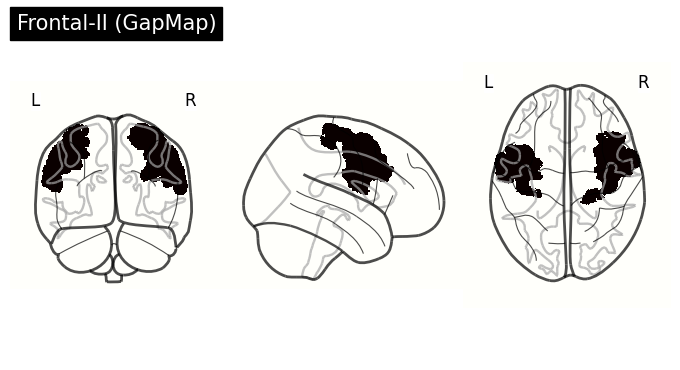

In [16]:
pcGapMap_mask = get_regional_mask('Frontal-II (GapMap)')

#### Primary Motor Cortex, Premotor Cortex and Supplementary Motor Area

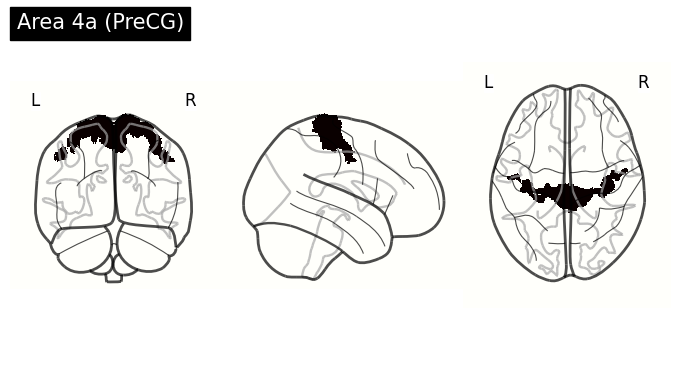

In [17]:
pc4a_mask = get_regional_mask('4a')

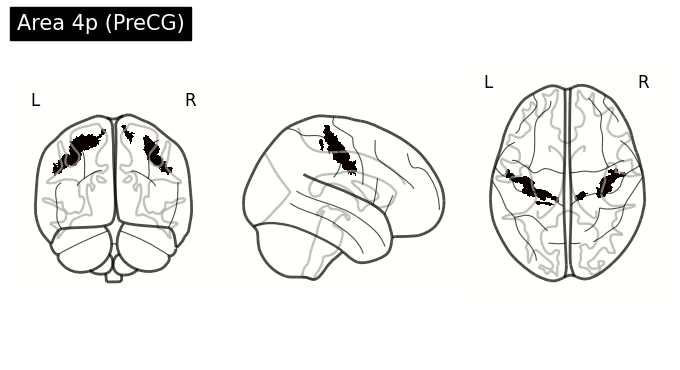

In [18]:
pc4p_mask = get_regional_mask('4p')

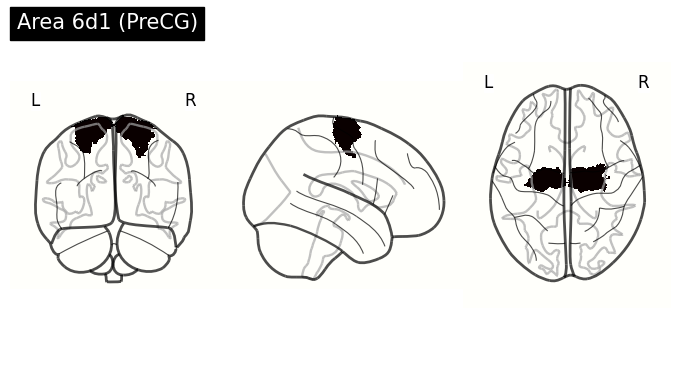

In [19]:
pc6d1_mask = get_regional_mask('6d1')

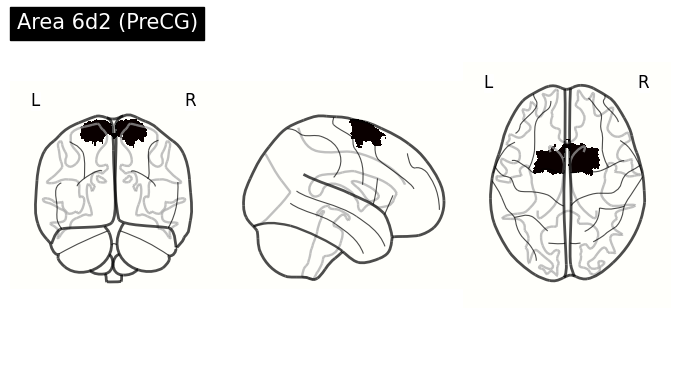

In [20]:
pc6d2_mask = get_regional_mask('6d2')

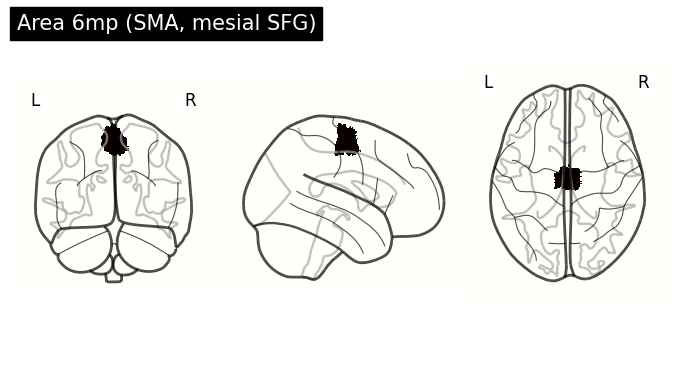

In [21]:
pc6mp = siibra.get_region(parcellation='julich 3.0.3', region='6mp')
child_region = pc6mp.children[0]
pc6mp_mask = child_region.get_regional_map(space="mni152", maptype="labelled")
display_6mp = plotting.plot_glass_brain(pc6mp_mask.fetch(), title=child_region.name, threshold=None) 

#### Sensory cortex

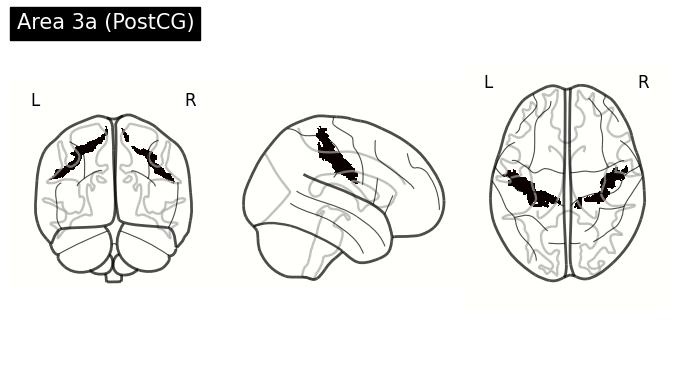

In [22]:
pc3a_mask = get_regional_mask('3a')

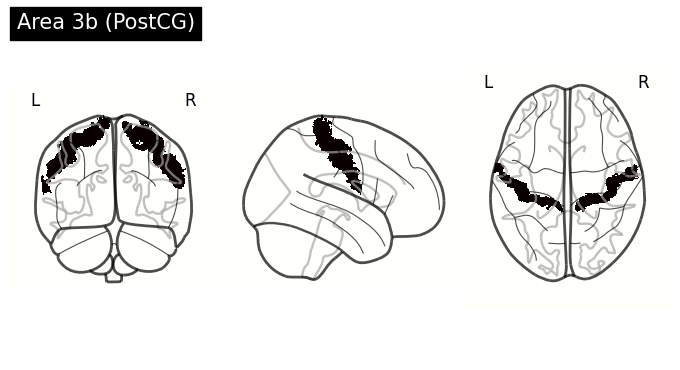

In [23]:
pc3b_mask = get_regional_mask('3b')

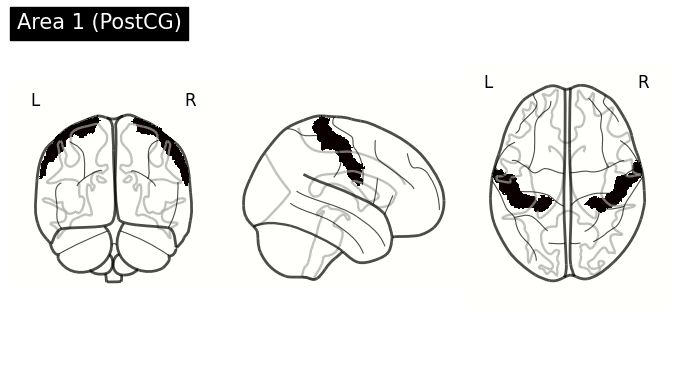

In [24]:
pc1_mask = get_regional_mask('1 (PostCG)')

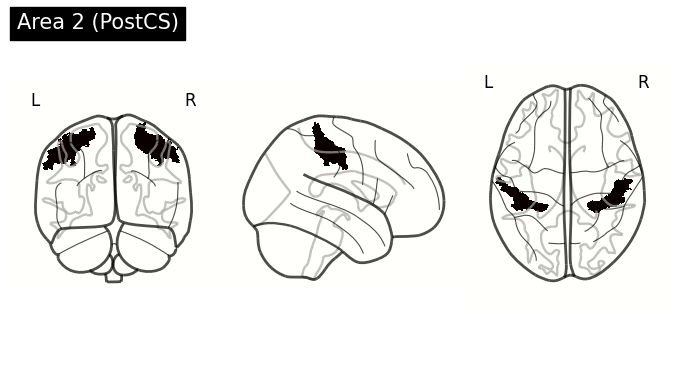

In [25]:
pc2_mask = get_regional_mask('2 (PostCS')

#### Resample the masks to the input voxel space

In [26]:
to_vox_map = (z_map.shape[:3], z_map.affine) #has attributes shape giving input voxel shape, and affine giving mapping of input voxels to output space

mask4a_resampled = resample_from_to(pc4a_mask.fetch(), to_vox_map, order=0) #  order=0: nearest neighbour interpolation
mask4p_resampled = resample_from_to(pc4p_mask.fetch(), to_vox_map, order=0)
mask6d1_resampled = resample_from_to(pc6d1_mask.fetch(), to_vox_map, order=0)
mask6d2_resampled = resample_from_to(pc6d2_mask.fetch(), to_vox_map, order=0)
mask6mp_resampled = resample_from_to(pc6mp_mask.fetch(), to_vox_map, order=0)
mask3a_resampled = resample_from_to(pc3a_mask.fetch(), to_vox_map, order=0)
mask3b_resampled = resample_from_to(pc3b_mask.fetch(), to_vox_map, order=0)
mask1_resampled = resample_from_to(pc1_mask.fetch(), to_vox_map, order=0)
mask2_resampled = resample_from_to(pc2_mask.fetch(), to_vox_map, order=0)
maskGapMap_resampled = resample_from_to(pcGapMap_mask.fetch(), to_vox_map, order=0)

## 4. Overlap between significant voxels in a statistical brain image and a specific brain region

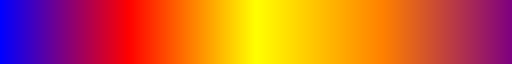

In [27]:
# Create a custom colormap
colors = [(0, 0, 1), (1, 0, 0), (1, 1, 0), (1, 0.5, 0), (0.5, 0, 0.5)]  # Blue, Red, Yellow, Orange, Purple
n_bins = 256
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)
cmap_custom

In [28]:
def plot_corrected_map(img, title, cmap, threshold):
    """
    Plot a corrected statistical map highlighting both positive (activation) and negative (deactivation) clusters.

    Parameters:
    img : Nifti1Image
        The input image containing statistical data.
    title : str
        Title for the plot.
    cmap : str
        Colormap to use for plotting.
    threshold : float
        Threshold value for significance.

    Returns:
    corrected_nifti_image : Nifti1Image
        The corrected NIfTI image with applied threshold.
    display : matplotlib.figure.Figure
        The matplotlib figure containing the plot.
    """
    data = img.get_fdata()
    
    # Create a mask for significant activations and deactivations
    mask = np.logical_or(data >= threshold, data <= -threshold)
    
    # Apply the mask to the data
    flattened_data = np.where(mask, data, 0)
    corrected_nifti_image = nib.Nifti1Image(flattened_data, affine=img.affine)
    
    # Plot the corrected statistical map
    display = plotting.plot_glass_brain(corrected_nifti_image, title=title, threshold=threshold, cmap=cmap, colorbar=True)
    
    return corrected_nifti_image


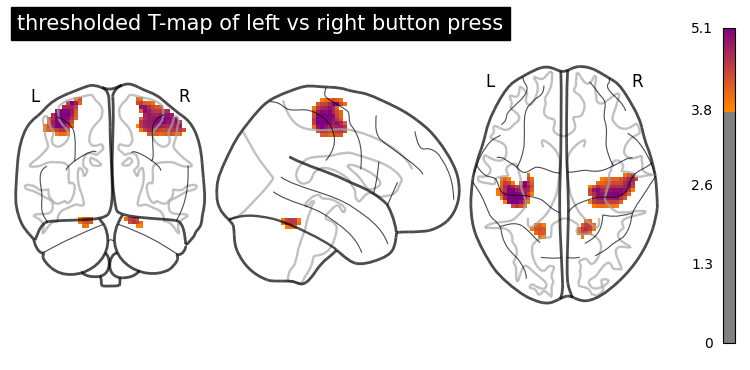

In [29]:
corrected_thresh_tmap = plot_corrected_map(thresholded_map, 'thresholded T-map of left vs right button press', cmap_custom, threshold)

In [30]:
def voxels_within_region(img, mask, description):
    """
    Calculation and visualization of the overlap between significant voxels in a 
    statistical brain image and a specific brain region defined by a binary mask.

    Parameters:
    img (Nifti1Image): The input statistical image containing voxel-wise data (e.g., p-values or t-values).
    mask (Nifti1Image): The binary mask image defining a specific brain region. Only voxels within this mask 
                        are considered for overlap analysis.
    description (str): A title or description for the analysis, used as the title for the glass brain plot.

    Returns:
    intersection_coordinates (numpy array): The coordinates of the significant voxels that lie within the 
                                            masked brain region.
    """
    
    disp = plotting.plot_glass_brain(img, title=description, threshold=None)
    disp.add_overlay(mask, alpha=0.3, cmap=cmap_custom)
    
    # Get the data arrays from the images
    p_values_data = img.get_fdata()
    mask_data_resampled = mask.get_fdata()

    # Get the voxel coordinates of the mask (where mask_data > 0)
    mask_coordinates = np.array(np.where(mask_data_resampled > 0.0)).T
    p_values_coordinates = np.array(np.where(p_values_data > 0.0)).T
    
    # Convert the coordinates to tuples for easier comparison
    coordinates_set1 = {tuple(coord) for coord in p_values_coordinates}
    coordinates_set2 = {tuple(coord) for coord in mask_coordinates}

    # Find the intersection of coordinates
    intersection_coordinates = np.array(list(coordinates_set1 & coordinates_set2))
    
    percentage_coordinates_results = (len(intersection_coordinates) / len(p_values_coordinates)) * 100

    print(f"Percentage of significant voxels within mask: {percentage_coordinates_results:.2f}%")
    
    return intersection_coordinates

#### Motor cortex

Percentage of significant voxels within mask: 13.29%


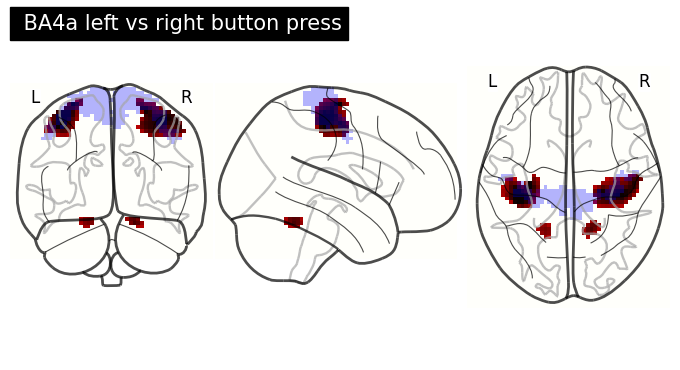

In [31]:
intersect_4a = voxels_within_region(corrected_thresh_tmap, mask4a_resampled, " BA4a left vs right button press")

Percentage of significant voxels within mask: 11.66%


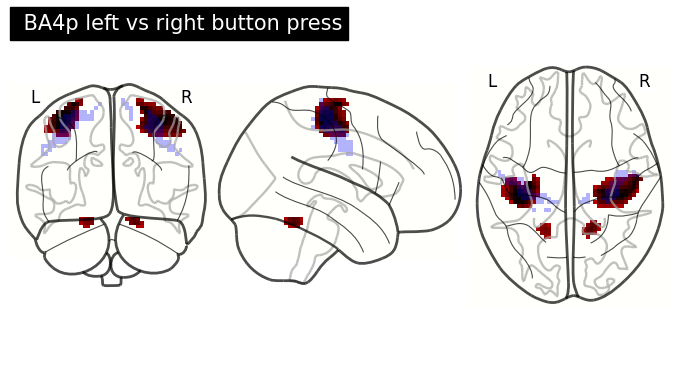

In [32]:
intersect_4p = voxels_within_region(corrected_thresh_tmap, mask4p_resampled, " BA4p left vs right button press")

Percentage of significant voxels within mask: 6.76%


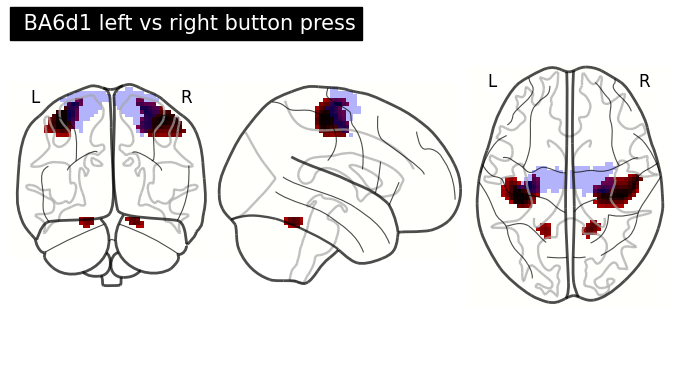

In [33]:
intersect_6d1 = voxels_within_region(corrected_thresh_tmap, mask6d1_resampled, " BA6d1 left vs right button press")

Percentage of significant voxels within mask: 0.00%


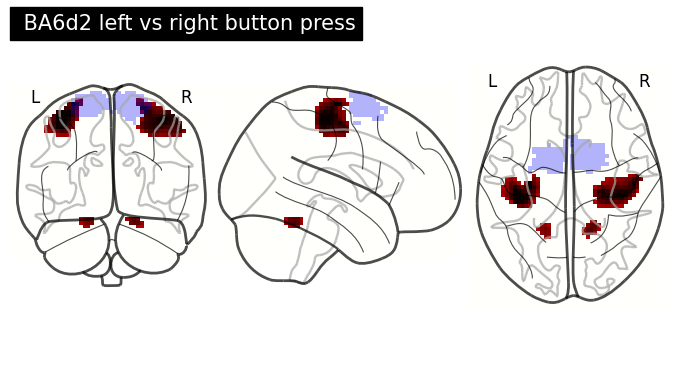

In [34]:
intersect_6d2 = voxels_within_region(corrected_thresh_tmap, mask6d2_resampled, " BA6d2 left vs right button press")

Percentage of significant voxels within mask: 0.00%


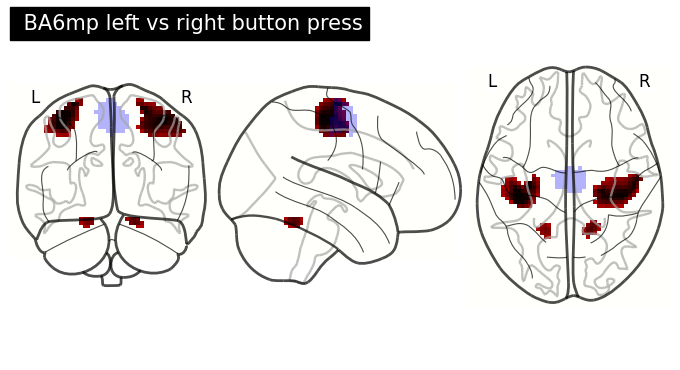

In [35]:
intersect_6mp = voxels_within_region(corrected_thresh_tmap, mask6mp_resampled, " BA6mp left vs right button press")

#### Frontal lobe

Percentage of significant voxels within mask: 16.32%


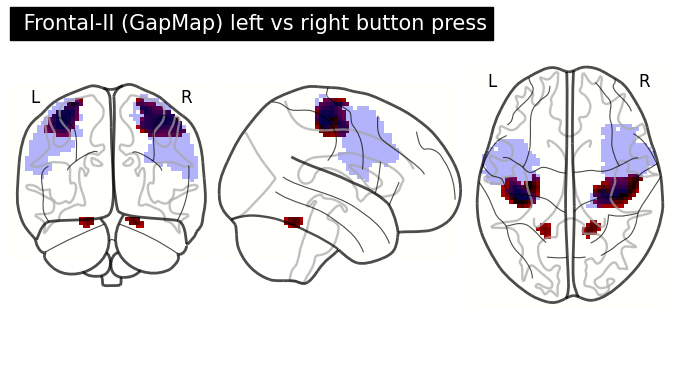

In [36]:
intersect_GapMap = voxels_within_region(corrected_thresh_tmap, maskGapMap_resampled, " Frontal-II (GapMap) left vs right button press")

#### Sensory Cortex

Percentage of significant voxels within mask: 3.73%


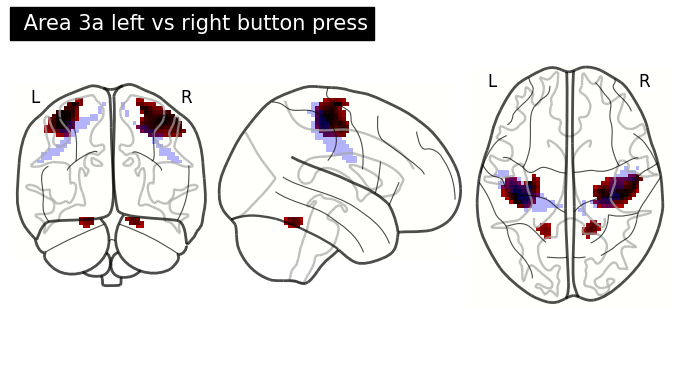

In [37]:
intersect_3a = voxels_within_region(corrected_thresh_tmap, mask3a_resampled, " Area 3a left vs right button press")

Percentage of significant voxels within mask: 17.72%


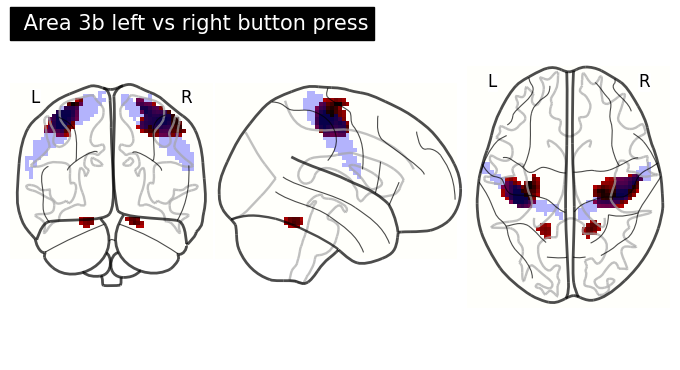

In [38]:
intersect_3b = voxels_within_region(corrected_thresh_tmap, mask3b_resampled, " Area 3b left vs right button press")

Percentage of significant voxels within mask: 11.66%


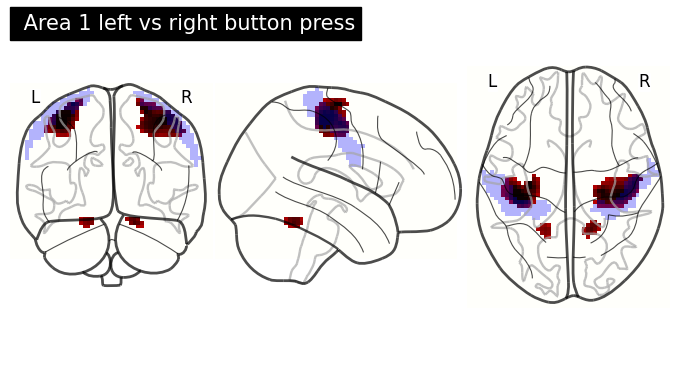

In [39]:
intersect_1 = voxels_within_region(corrected_thresh_tmap, mask1_resampled, " Area 1 left vs right button press")

Percentage of significant voxels within mask: 9.32%


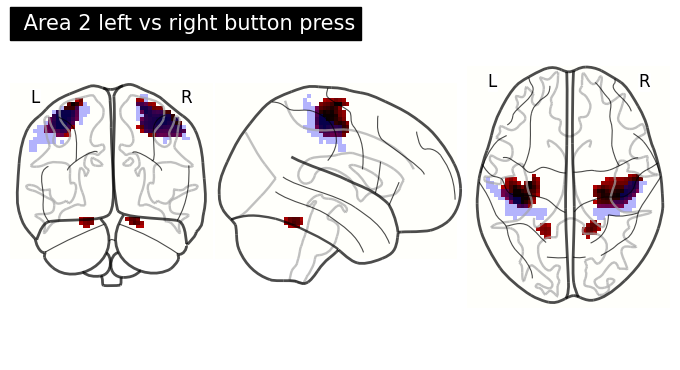

In [40]:
intersect_2 = voxels_within_region(corrected_thresh_tmap, mask2_resampled, " Area 2 left vs right button press")

#### Overview of Results: Distribution of Significant Voxels Across Brain Regions

In [41]:
percent = [13.29, 11.66, 6.76, 0, 0, 3.73, 17.72, 11.66, 9.32, 16.32]

In [42]:
regions = ['4a', '4p', '6d1', '6d2', '6mp', '3a', '3b', '1', '2', 'Frontal-II-GapMap']

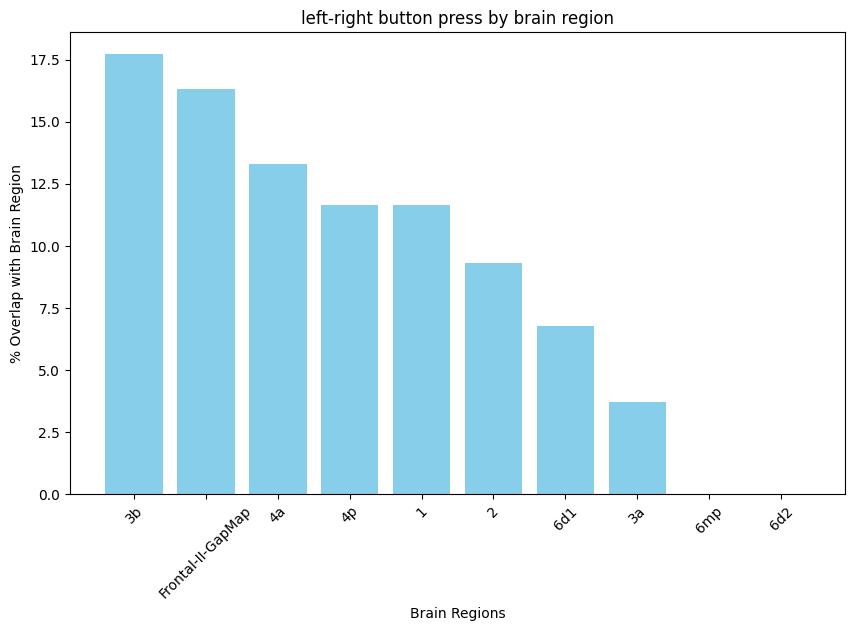

In [43]:
# Sort data based on percentage values in descending order
percent, regions = zip(*sorted(zip(percent, regions), reverse=True))

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(regions, percent, color='skyblue')
plt.xlabel('Brain Regions')
plt.ylabel('% Overlap with Brain Region')
plt.title('left-right button press by brain region')
plt.xticks(rotation=45)
plt.show()